In [43]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

In [2]:
# load data
downloads = pd.read_csv("dataset/downloads.csv")
members = pd.read_csv("dataset/members.csv")

In [3]:
# overview of downloads
downloads.head()

uid                              supplier  \
0  e98a4c15-2cb5-4ed1-b57f-30371300fd5f  8107867a-1f4a-4035-9c1d-8ed03d2ec2cd   
1  10870f27-fe41-4bae-8ed4-f93ee45210e8  76d62316-3394-4824-aa2b-117cc6f0ca83   
2  79b326f5-eab7-4f18-92c2-608c184ace1d  4a160b61-23e1-42ef-b59a-4ea253f504bc   
3  25267a99-0c27-49f9-bb8f-37c3359aeb21  da46eaba-d7ac-4c8a-9c40-ae0e46e68d08   
4  6515c23b-31ea-429e-a9f1-135cc4afcf3a  b3287ba9-40d6-4cfc-95d9-e4fd840889f1   

    image_id   res  dlType        date_download  dlyear  dlmonth  dlday  \
0  197093672  mega       3  2024-09-30 23:59:55    2024        9     30   
1   16357128   NaN       2  2024-09-30 23:59:49    2024        9     30   
2   46529682   NaN       5  2024-09-30 23:59:41    2024        9     30   
3   84208353   NaN       5  2024-09-30 23:59:38    2024        9     30   
4  174899950   med       3  2024-09-30 23:59:34    2024        9     30   

   fraud  file_type  
0      0          0  
1      0          1  
2      0          1  
3      0          1  
4      0          0

In [4]:
# overview of members
members.head()

uid date_register country  contributor
0  c116eaf6-adae-4695-9dbc-f416e16bf9fd    2005-06-01      KR            1
1  88dcad39-de41-4193-a31a-406cefb2e5fa    2005-06-01      CA            1
2  a7cc4e9e-9e9a-4682-862f-7ba8776c10d4    2005-06-06      FX            1
3  0937ff63-d59a-44f3-bcb9-0ec34f38aebf    2005-06-06      RU            1
4  c0579051-41bd-4629-9ab3-1e149da03c05    2005-06-06      ZA            1

In [5]:
# check total number of uid in members that are not in downloads
uid_not_in_downloads = members[~members['uid'].isin(downloads['uid'])]
total_uid_not_in_downloads = uid_not_in_downloads['uid'].count()

print(f"number of uid in members that are not in downloads: {total_uid_not_in_downloads}")

number of uid in members that are not in downloads: 67859


In [6]:
# merge downloads and members data based on uid
data = pd.merge(downloads, members, on = "uid", how = "left")

# convert date columns to datetime for easier filtering
data['date_download'] = pd.to_datetime(data['date_download'])
data['date_register'] = pd.to_datetime(data['date_register'])

data.head()

uid                              supplier  \
0  e98a4c15-2cb5-4ed1-b57f-30371300fd5f  8107867a-1f4a-4035-9c1d-8ed03d2ec2cd   
1  10870f27-fe41-4bae-8ed4-f93ee45210e8  76d62316-3394-4824-aa2b-117cc6f0ca83   
2  79b326f5-eab7-4f18-92c2-608c184ace1d  4a160b61-23e1-42ef-b59a-4ea253f504bc   
3  25267a99-0c27-49f9-bb8f-37c3359aeb21  da46eaba-d7ac-4c8a-9c40-ae0e46e68d08   
4  6515c23b-31ea-429e-a9f1-135cc4afcf3a  b3287ba9-40d6-4cfc-95d9-e4fd840889f1   

    image_id   res  dlType       date_download  dlyear  dlmonth  dlday  fraud  \
0  197093672  mega       3 2024-09-30 23:59:55    2024        9     30      0   
1   16357128   NaN       2 2024-09-30 23:59:49    2024        9     30      0   
2   46529682   NaN       5 2024-09-30 23:59:41    2024        9     30      0   
3   84208353   NaN       5 2024-09-30 23:59:38    2024        9     30      0   
4  174899950   med       3 2024-09-30 23:59:34    2024        9     30      0   

   file_type date_register country  contributor  
0          0    2021-08-16      TW            0  
1          1    2020-02-07      TH            0  
2          1    2013-05-06      KR            0  
3          1    2013-03-27      US            0  
4          0    2012-06-18      HK            0

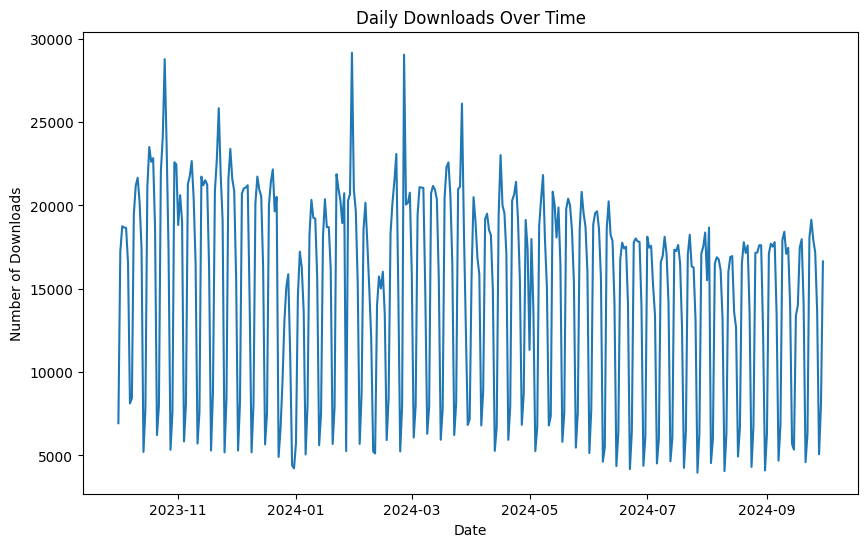

In [7]:
# aggregate downloads by day
daily_downloads = data.groupby(data['date_download'].dt.date).size()
daily_downloads = daily_downloads.sort_index()

# plot daily downloads
plt.figure(figsize = (10, 6))
daily_downloads.plot(title = "Daily Downloads Over Time")
plt.ylabel("Number of Downloads")
plt.xlabel("Date")
plt.show()

In [8]:
# calculate the difference between consecutive days
daily_downloads_diff = daily_downloads.diff()

# identify drops (negative values)
drops = daily_downloads_diff[daily_downloads_diff < 0]

# initialize a list to store the results
drop_info = []

# for each drop, find the day after where the downloads start increasing
for drop_date in drops.index:
    if len(drop_info) != 0:
        if drop_date < drop_info[-1]["recovery_date"]:
            continue

    drop_value = drops[drop_date]

    # find recovery date
    recovery_date = daily_downloads_diff[drop_date:].gt(0).idxmax()

    # identify the biggest drop within the drop and recovery period
    drop_position = daily_downloads.index.get_loc(drop_date)
    recovery_date_position = daily_downloads.index.get_loc(recovery_date)
    previous_drop_date = daily_downloads.index[drop_position - 1]
    previous_drop_value = daily_downloads.iloc[drop_position - 1]
    previous_recovery_date = daily_downloads.index[recovery_date_position - 1]
    drop_period = daily_downloads[drop_date:previous_recovery_date]
    # drop_period = daily_downloads[drop_date:recovery_date - pd.Timedelta(days = 1)]
    biggest_drop_value = drop_period.min()
    biggest_drop_date = drop_period.idxmin() # get the date of the biggest drop

    drop_info.append({
        "before_start_drop_date": previous_drop_date,
        "before_start_drop_value": previous_drop_value,
        "start_drop_date": drop_date,
        "start_drop_value": daily_downloads[drop_date],
        "recovery_date": recovery_date,
        "recovery_date_value": daily_downloads[recovery_date],
        "biggest_drop_date": biggest_drop_date,
        "biggest_drop_value": daily_downloads[biggest_drop_date]
    })

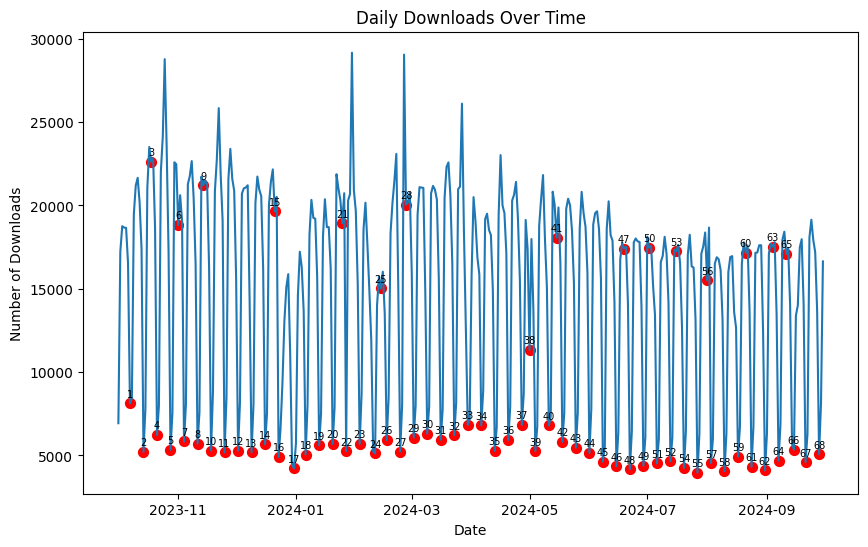

In [9]:
plt.figure(figsize = (10, 6))
daily_downloads.plot(title = "Daily Downloads Over Time")
plt.ylabel("Number of Downloads")
plt.xlabel("Date")

# counter to number the annotations
counter = 1

for drop in drop_info:
    plt.scatter(drop['biggest_drop_date'], drop['biggest_drop_value'], 
        color = 'red', s = 50)
    
    # add text annotation
    plt.text(drop['biggest_drop_date'], drop['biggest_drop_value'] + 250, 
             str(counter), color = 'black', fontsize = 7, ha = 'center', va = 'bottom')

    counter += 1

plt.show()

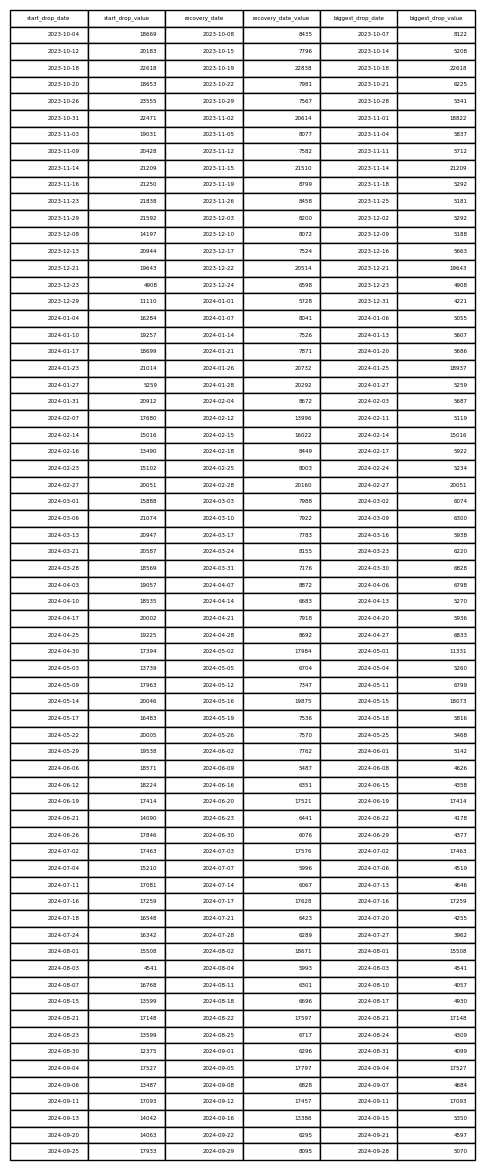

In [10]:
# converting list of dictionaries to a dataframe
drop_info_df = pd.DataFrame(drop_info)
drop_info_overall_df = drop_info_df[[col for col in drop_info_df.columns if col not in ['before_start_drop_date', 'before_start_drop_value']]]

# plot the dataframe as a table
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=drop_info_overall_df.values, colLabels=drop_info_overall_df.columns, loc='center')

# save as an image
plt.savefig("images/overall_drop_table.png", dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# find the entry with the biggest drop value
min_drop_entry = min(drop_info, key = lambda x: x['biggest_drop_value'])

print(f"the biggest drop value is {min_drop_entry['biggest_drop_value']} on {min_drop_entry['biggest_drop_date']}")

the biggest drop value is 3962 on 2024-07-27


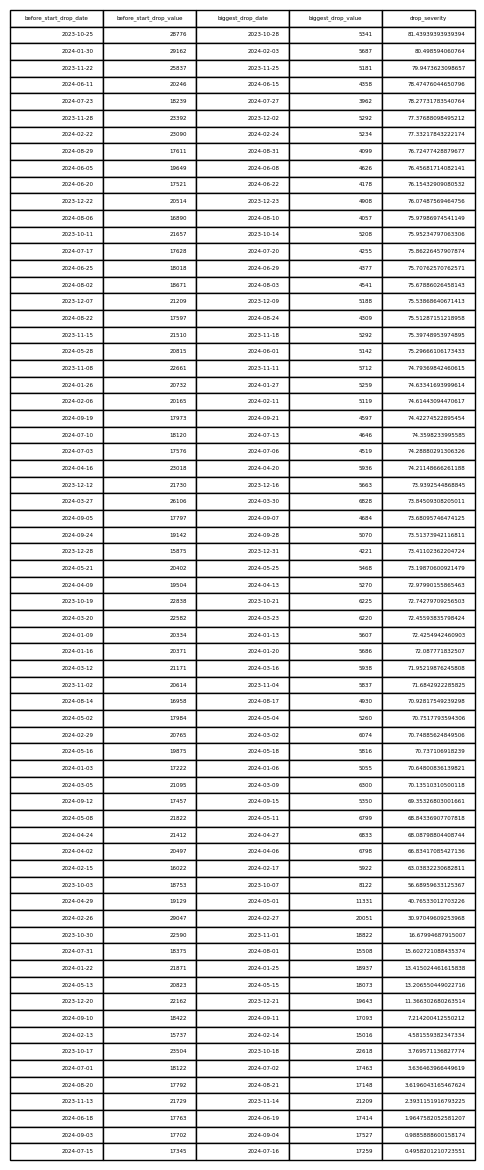

In [12]:
# drop severity (percentage drop)
drop_info_df['drop_severity'] = (drop_info_df['before_start_drop_value'] - drop_info_df['biggest_drop_value']) / drop_info_df['before_start_drop_value'] * 100

percentage_drop_df = drop_info_df[['before_start_drop_date', 'before_start_drop_value', 'biggest_drop_date', 'biggest_drop_value', 'drop_severity']]
percentage_drop_df = percentage_drop_df.sort_values(by='drop_severity', ascending=False)

# plot the dataframe as a table
fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=percentage_drop_df.values, colLabels=percentage_drop_df.columns, loc='center')

# save as an image
plt.savefig("images/percentage_drop_table.png", dpi=300, bbox_inches='tight')
plt.show()

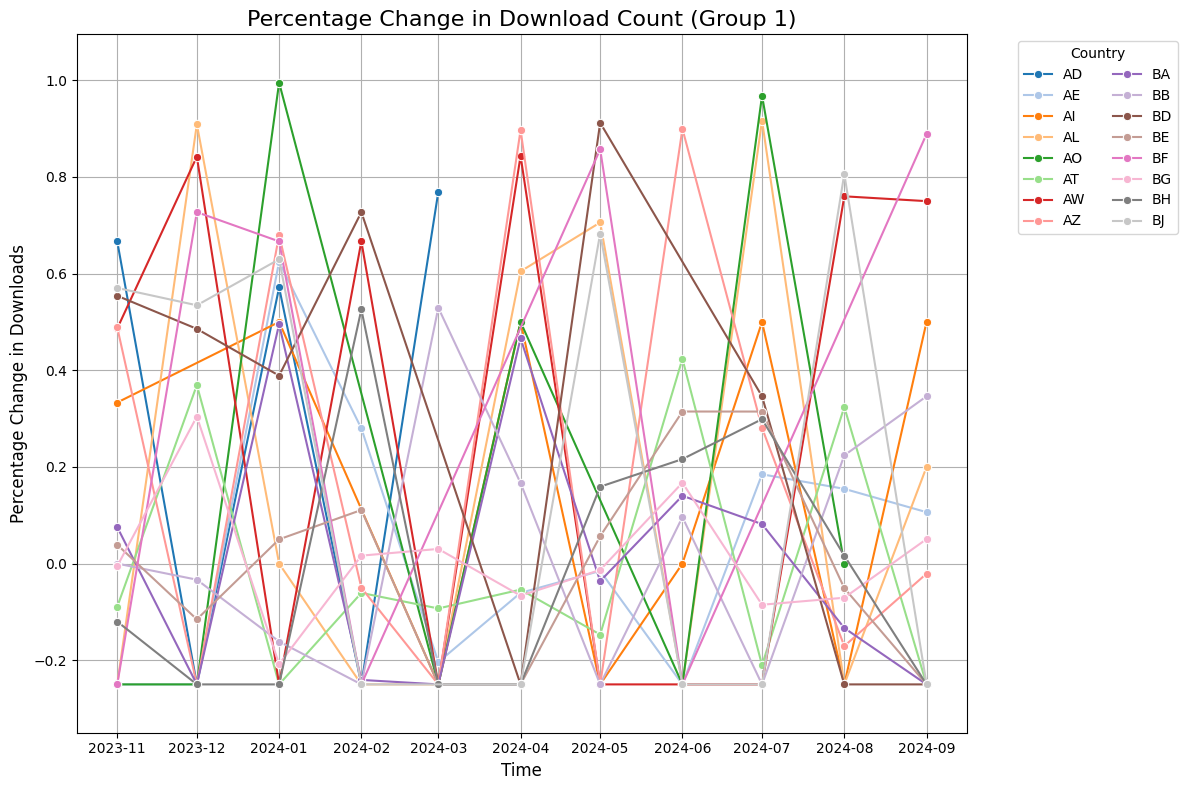

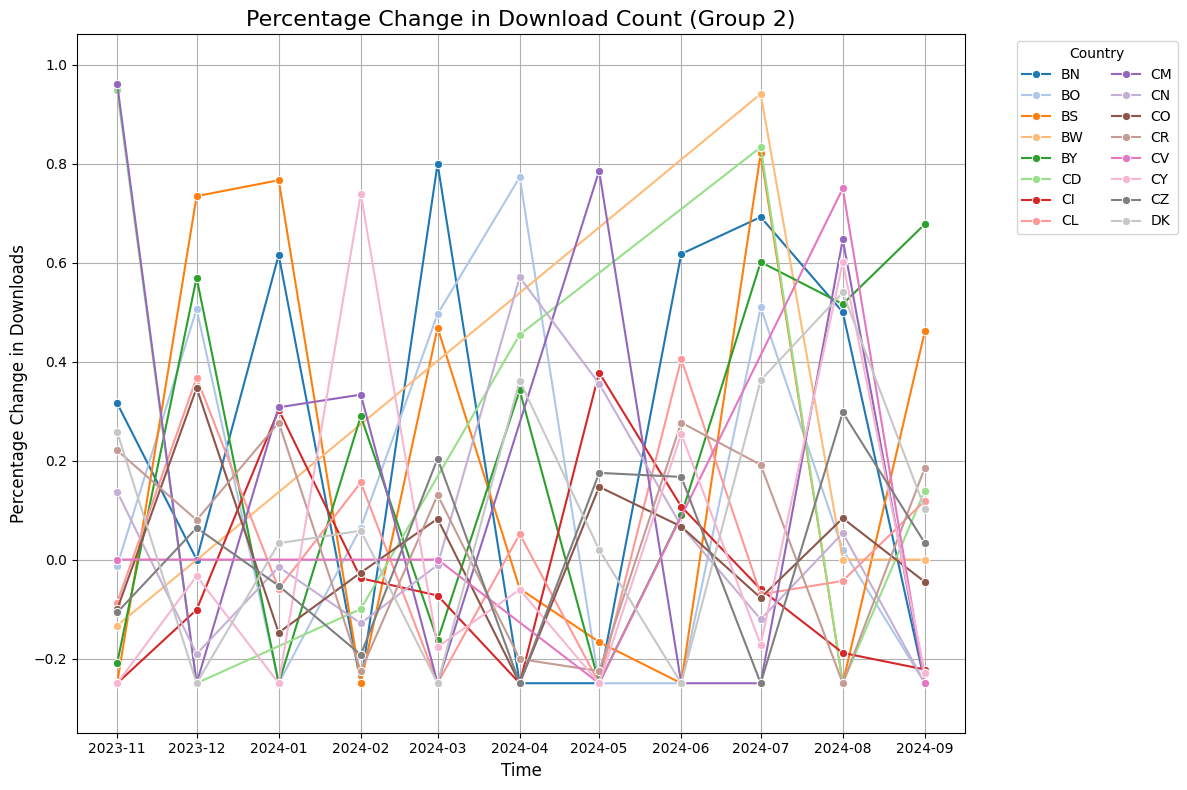

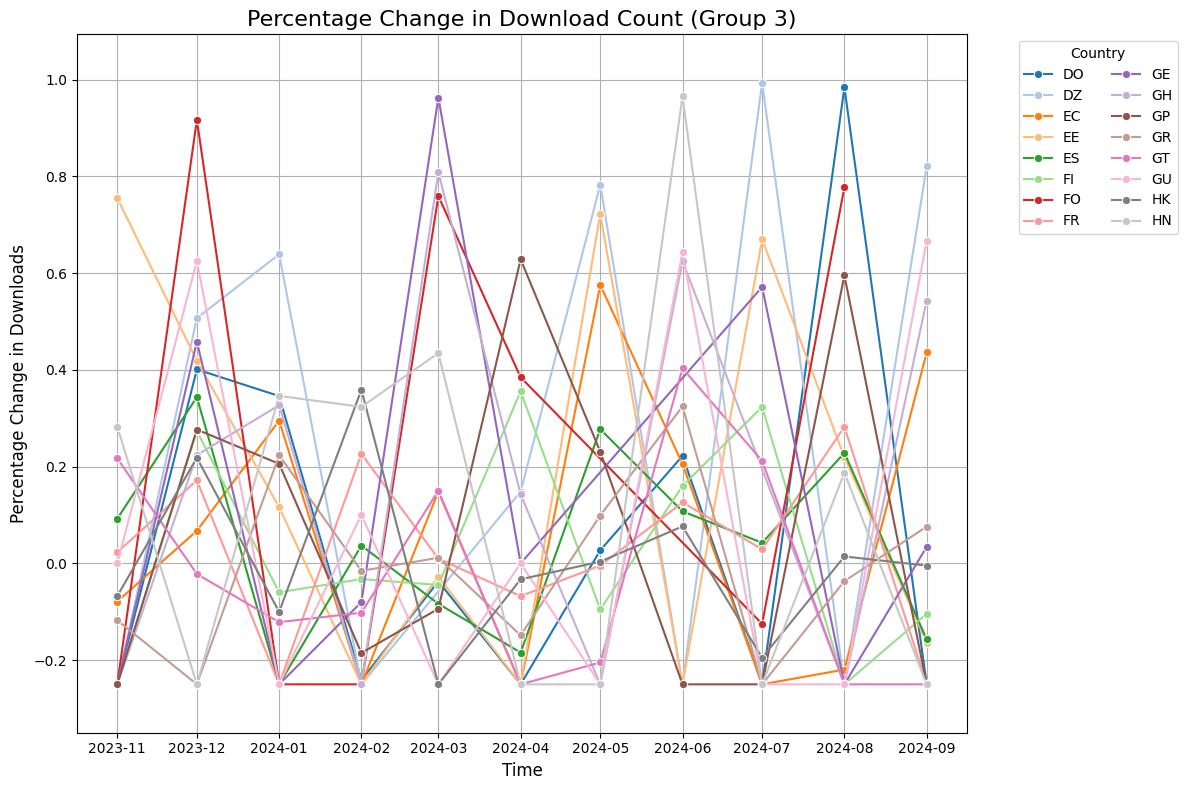

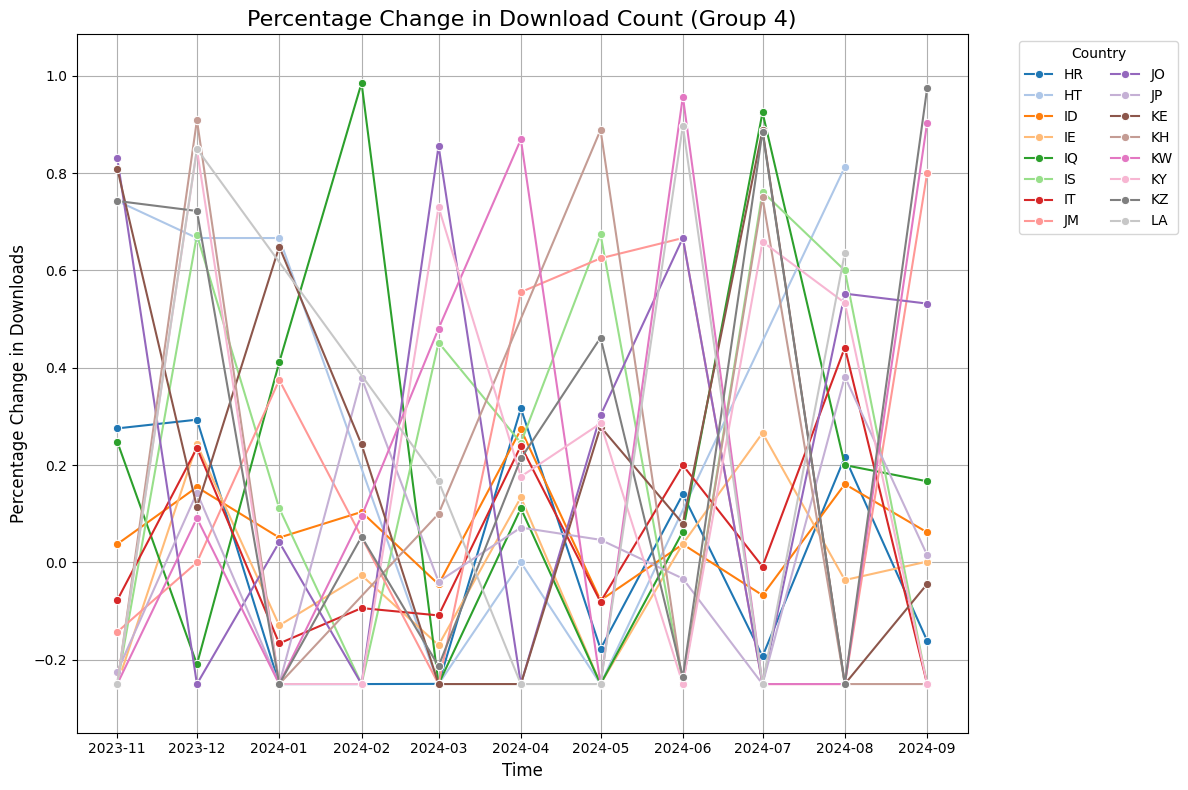

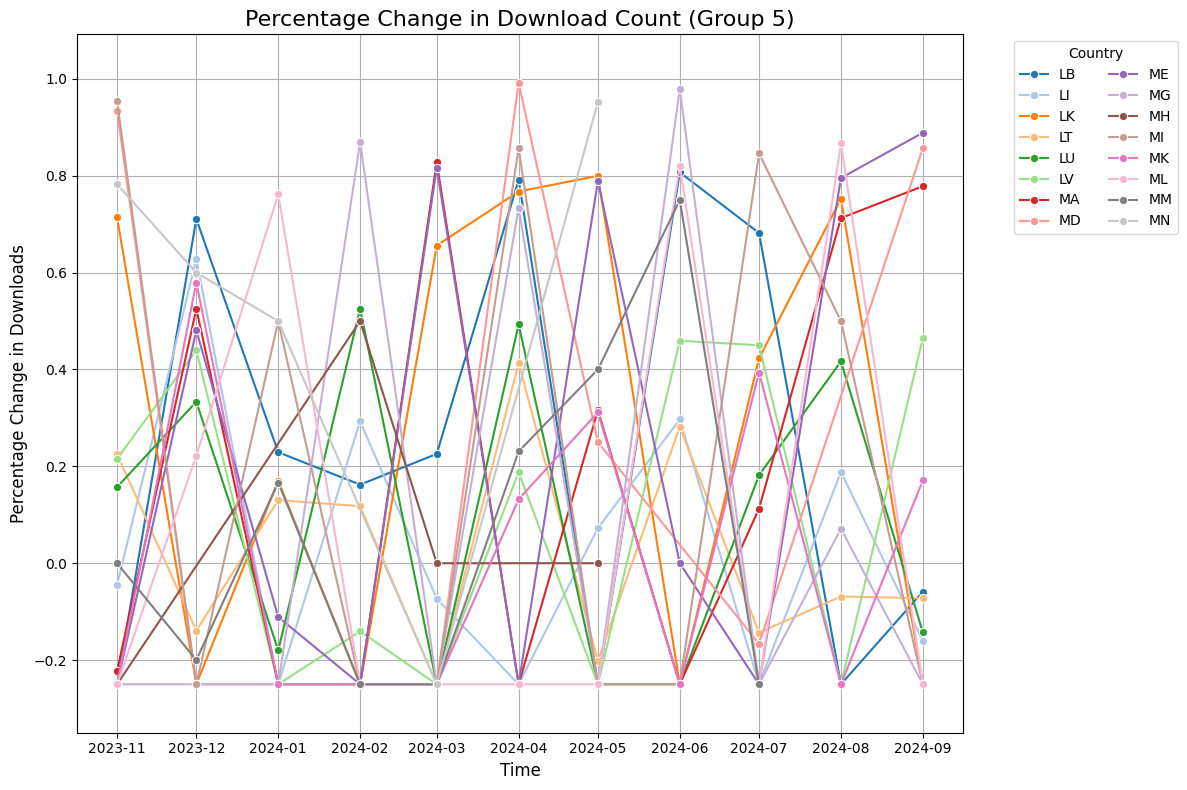

C:\Users\tellw\AppData\Local\Temp\ipykernel_12780\306687445.py:26: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.lineplot(


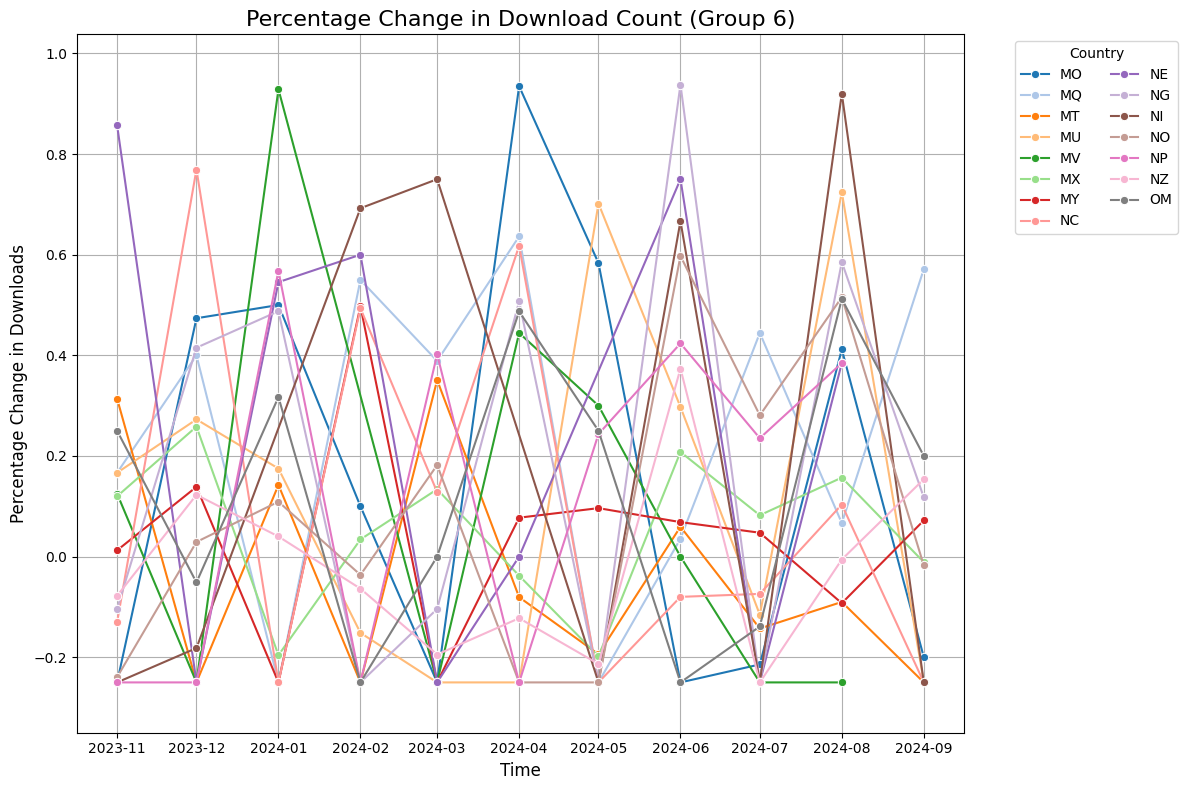

C:\Users\tellw\AppData\Local\Temp\ipykernel_12780\306687445.py:26: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.lineplot(


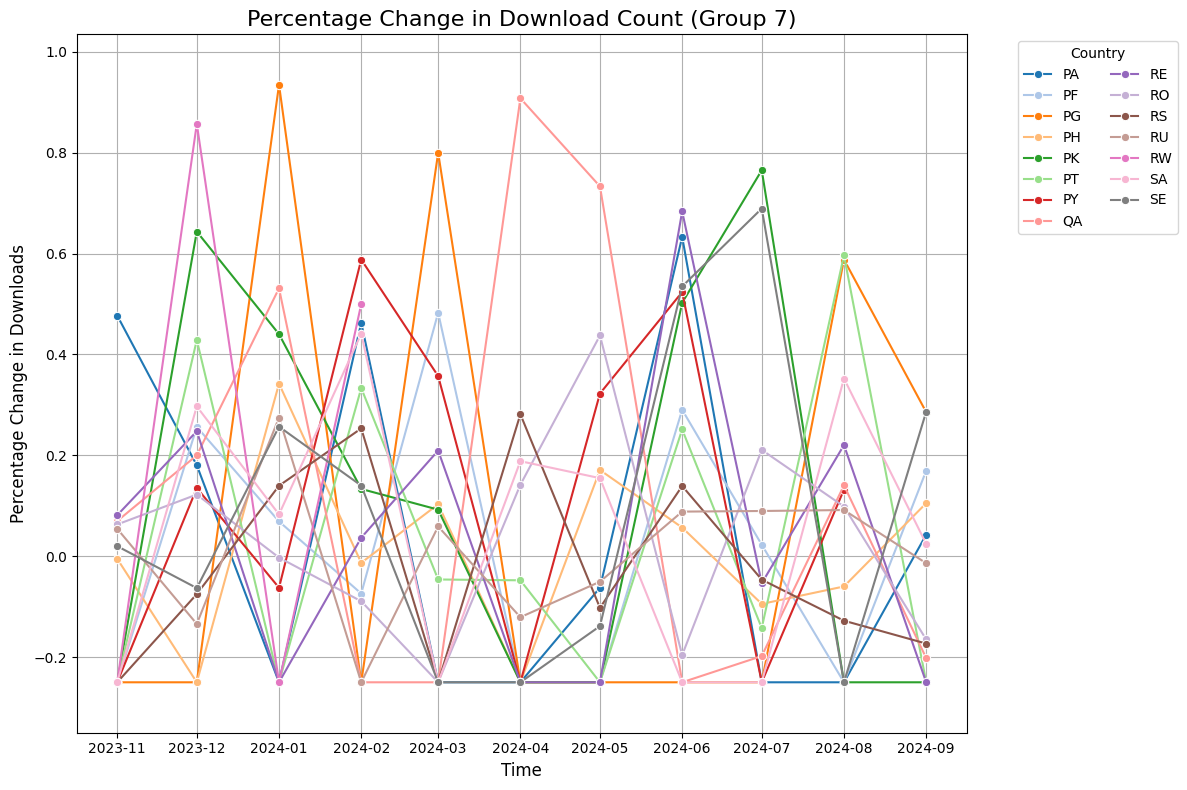

C:\Users\tellw\AppData\Local\Temp\ipykernel_12780\306687445.py:26: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.lineplot(


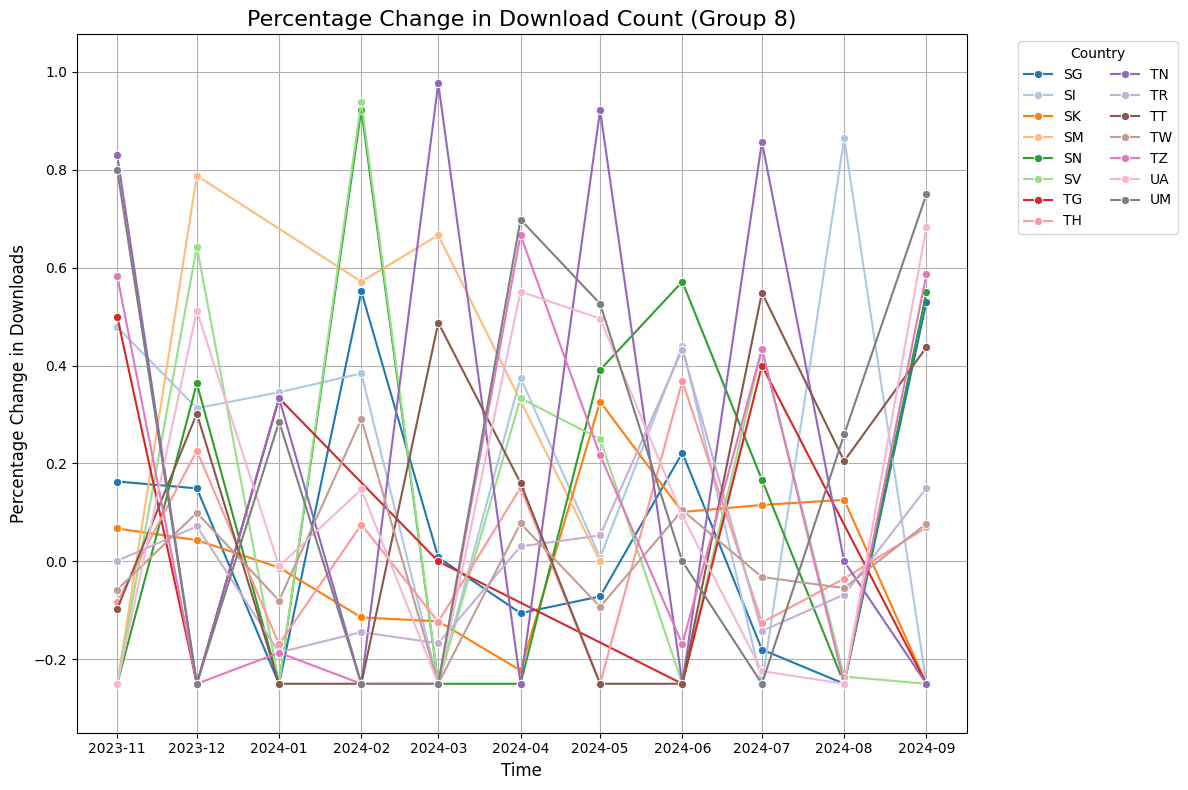

C:\Users\tellw\AppData\Local\Temp\ipykernel_12780\306687445.py:26: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.lineplot(


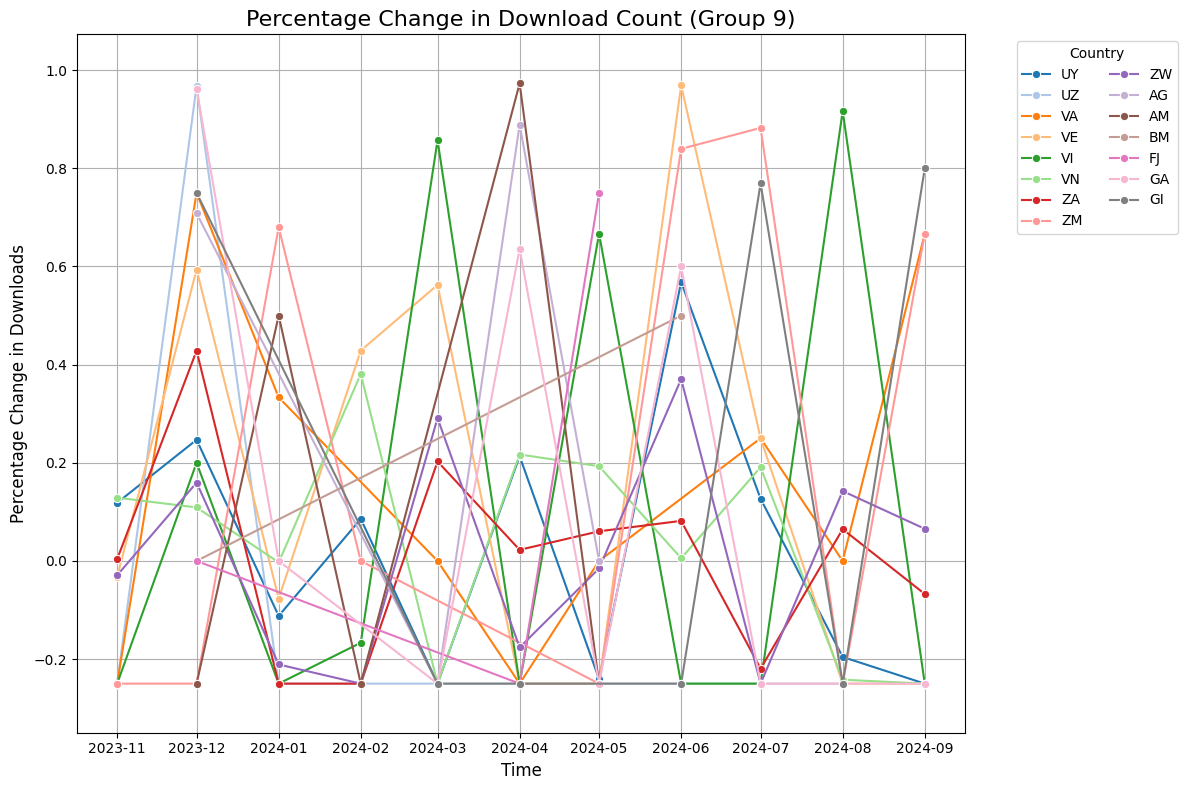

C:\Users\tellw\AppData\Local\Temp\ipykernel_12780\306687445.py:26: UserWarning: The palette list has more values (16) than needed (15), which may not be intended.
  sns.lineplot(


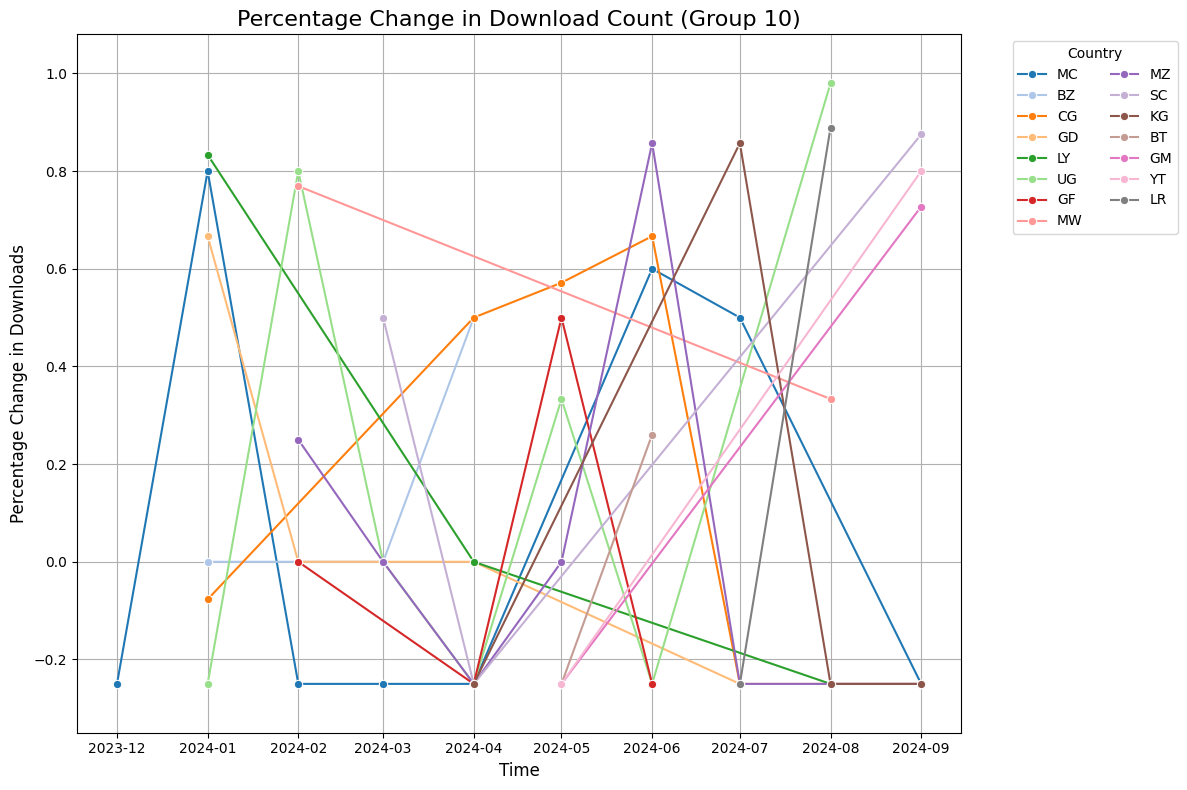

In [13]:
# drop attribute to countries
downloads_grouped = data.groupby(['dlyear', 'dlmonth', 'country']).size().reset_index(name='download_count')
downloads_grouped['pct_change'] = downloads_grouped.groupby('country')['download_count'].pct_change()
downloads_grouped['time'] = pd.to_datetime(
    downloads_grouped['dlyear'].astype(str) + '-' + downloads_grouped['dlmonth'].astype(str)
)
downloads_grouped = downloads_grouped.dropna(subset=['pct_change'])
downloads_grouped['pct_change_plot'] = -downloads_grouped['pct_change']
downloads_grouped['pct_change_plot'] = downloads_grouped['pct_change_plot'].clip(lower=-0.25)

serious_drop_countries = downloads_grouped.groupby('country')['pct_change_plot'].max()
serious_drop_countries = serious_drop_countries[serious_drop_countries > 0.25].index

downloads_grouped_filtered = downloads_grouped[downloads_grouped['country'].isin(serious_drop_countries)]
downloads_grouped_filtered = downloads_grouped_filtered.groupby('country').filter(lambda x: len(x) > 1)

countries = downloads_grouped_filtered['country'].unique()
split_countries = np.array_split(countries, 10)
palette = sns.color_palette("tab20", n_colors=16)

for i, country_group in enumerate(split_countries, 1):
    plt.figure(figsize=(12, 8))

    subset = downloads_grouped_filtered[downloads_grouped_filtered['country'].isin(country_group)]

    sns.lineplot(
        data=subset,
        x='time',
        y='pct_change_plot',
        hue='country',
        palette=palette,
        marker='o'
    )

    plt.ylim(subset['pct_change_plot'].min() - 0.1, subset['pct_change_plot'].max() + 0.1)
    plt.title(f'Percentage Change in Download Count (Group {i})', fontsize=16)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Percentage Change in Downloads', fontsize=12)
    plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.grid(True)
    plt.tight_layout()

    plt.show()

In [14]:
# drop associate with user
user_activity = data.groupby(['uid', 'dlyear', 'dlmonth']).size().reset_index(name='activity_count')
user_activity['pct_change'] = user_activity.groupby('uid')['activity_count'].pct_change()

threshold = -0.5
serious_drop_users = user_activity[user_activity['pct_change'] < threshold]
serious_drop_users

uid  dlyear  dlmonth  activity_count  \
16      0007aedf-109a-4044-82c1-fa8696471ab0    2023       11              81   
25      0007aedf-109a-4044-82c1-fa8696471ab0    2024        8              57   
36      000d9c4d-5bc1-453e-8b9f-17c708d4917f    2023       12               2   
42      000d9c4d-5bc1-453e-8b9f-17c708d4917f    2024        6               4   
47      000dfe3e-4b14-4606-8102-c56a880e02a8    2023       11               1   
...                                      ...     ...      ...             ...   
228045  ffef3056-317c-4475-8151-4ade6f01478b    2024        1               1   
228048  fff2da82-8f92-406f-8f9d-487977aed815    2024        2               2   
228050  fff2da82-8f92-406f-8f9d-487977aed815    2024        9               4   
228054  fff8c695-a9fb-4e3d-ad07-21fc9ec87dd2    2024        8               2   
228058  fffb5132-7838-4207-833d-0c456ff626a6    2024        8               1   

        pct_change  
16       -0.506098  
25       -0.561538  
36       -0.600000  
42       -0.555556  
47       -0.750000  
...            ...  
228045   -0.750000  
228048   -0.600000  
228050   -0.714286  
228054   -0.931034  
228058   -0.800000  

[28395 rows x 5 columns]

small downloaders: 67748
major downloaders: 17093
small downloaders contribute: 4.42%
major downloaders contribute: 95.58%


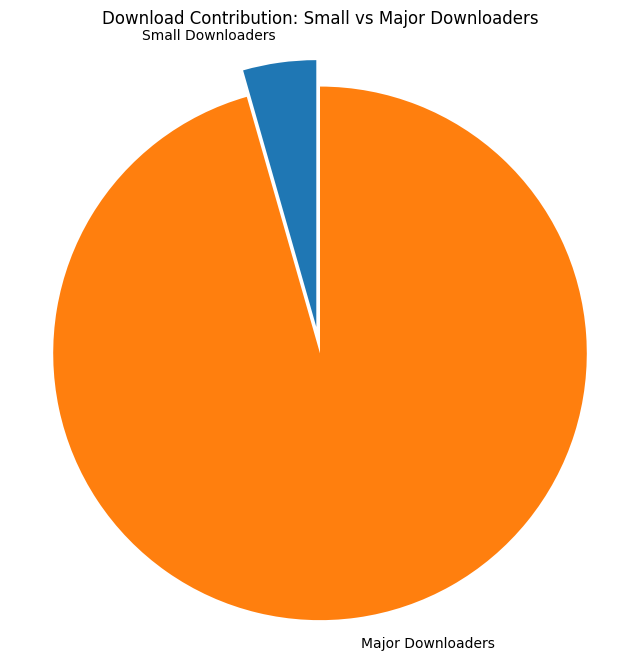

In [15]:
# drop comming fro many/ small downloaders
user_total_downloads = data.groupby('uid').size().reset_index(name='total_downloads')
user_total_downloads = user_total_downloads.sort_values(by='total_downloads', ascending=False)

threshold = user_total_downloads['total_downloads'].quantile(0.8)

small_downloaders = user_total_downloads[user_total_downloads['total_downloads'] < threshold]
major_downloaders = user_total_downloads[user_total_downloads['total_downloads'] >= threshold]

print(f"small downloaders: {len(small_downloaders)}")
print(f"major downloaders: {len(major_downloaders)}")

small_downloaders_total = small_downloaders['total_downloads'].sum()
major_downloaders_total = major_downloaders['total_downloads'].sum()

total_downloads = user_total_downloads['total_downloads'].sum()

small_downloaders_percentage = (small_downloaders_total / total_downloads) * 100
major_downloaders_percentage = (major_downloaders_total / total_downloads) * 100

print(f"small downloaders contribute: {small_downloaders_percentage:.2f}%")
print(f"major downloaders contribute: {major_downloaders_percentage:.2f}%")

labels = ['Small Downloaders', 'Major Downloaders']
sizes = [small_downloaders_percentage, major_downloaders_percentage]
explode = (0.1, 0)

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, startangle=90, explode=explode)
plt.title('Download Contribution: Small vs Major Downloaders')
plt.axis('equal')
plt.show()

top 10% downloaders contribute: 9.95% of total downloads


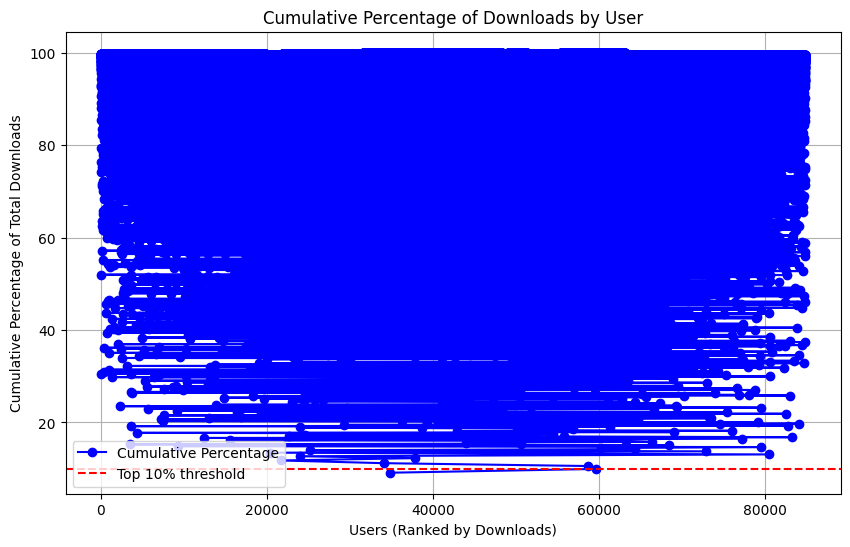

In [16]:
user_total_downloads['cumulative_downloads'] = user_total_downloads['total_downloads'].cumsum()
user_total_downloads['cumulative_percentage'] = (user_total_downloads['cumulative_downloads'] / total_downloads) * 100

top_percent = 10
top_contributors = user_total_downloads[user_total_downloads['cumulative_percentage'] <= top_percent]

print(f"top {top_percent}% downloaders contribute: {top_contributors['cumulative_percentage'].iloc[-1]:.2f}% of total downloads")

plt.figure(figsize=(10, 6))
plt.plot(user_total_downloads['cumulative_percentage'], marker='o', color='b', linestyle='-', label='Cumulative Percentage')
plt.axhline(y=top_percent, color='r', linestyle='--', label=f'Top {top_percent}% threshold')
plt.title('Cumulative Percentage of Downloads by User')
plt.xlabel('Users (Ranked by Downloads)')
plt.ylabel('Cumulative Percentage of Total Downloads')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\tellw\AppData\Local\Temp\ipykernel_12780\2283686327.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sizes = [holiday_vs_non_holiday[0], holiday_vs_non_holiday[1]]


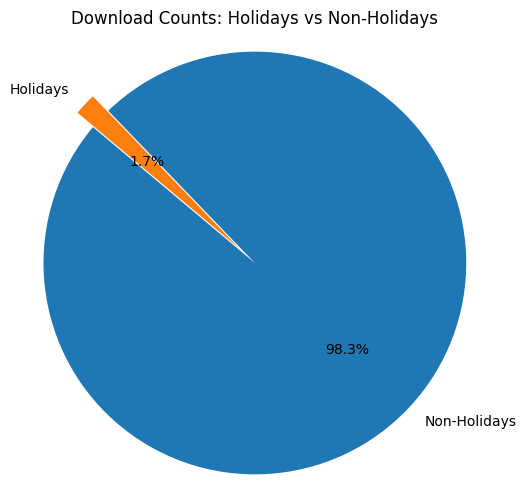

In [26]:
malaysia_data = data[data['country'] == 'MY'].copy()
pb_2023 = ['2023-01-01', '2023-01-22', '2023-01-23', '2023-04-21', '2023-04-22', 
 '2023-05-01', '2023-05-05', '2023-06-05', '2023-08-31', '2023-06-28', 
 '2023-11-12', '2023-12-25']
pb_2024 = ['2024-01-01', '2024-02-10', '2024-02-11', '2024-03-10', '2024-03-11', 
 '2024-05-01', '2024-05-23', '2024-06-05', '2024-08-31', '2024-06-16', 
 '2024-11-01', '2024-12-25']
pb_2023_datetime = pd.to_datetime(pb_2023)
pb_2024_datetime = pd.to_datetime(pb_2024)
all_public_holidays = pb_2023_datetime.append(pb_2024_datetime)

malaysia_data['is_public_holiday'] = malaysia_data['date_download'].apply(lambda x: x.date() in all_public_holidays.date)
holiday_vs_non_holiday = malaysia_data.groupby('is_public_holiday').size()

labels = ['Non-Holidays', 'Holidays']
sizes = [holiday_vs_non_holiday[0], holiday_vs_non_holiday[1]]
explode = (0.1, 0)

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode)
plt.title('Download Counts: Holidays vs Non-Holidays')
plt.axis('equal')
plt.show()

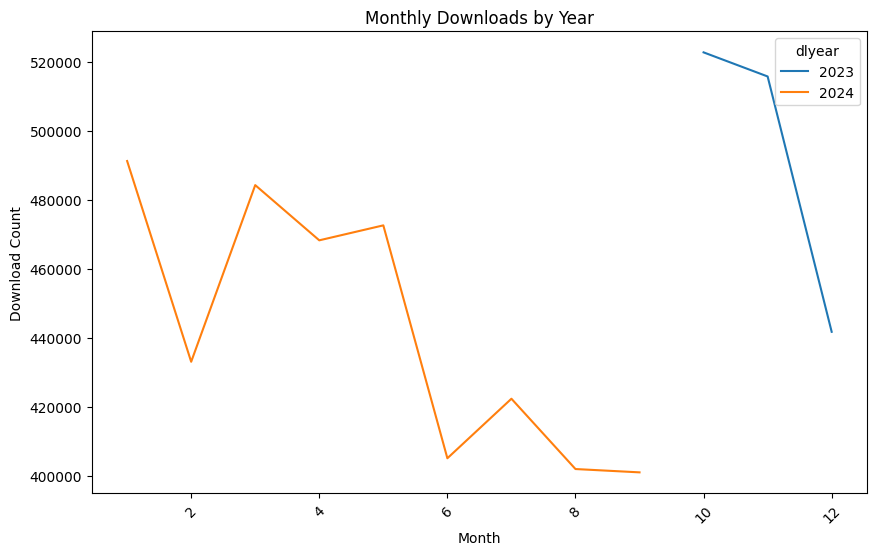

In [ ]:
# seasonality of downloads
monthly_downloads = data.groupby(['dlyear', 'dlmonth']).size()
monthly_downloads = monthly_downloads.unstack(level=0)
monthly_downloads.plot(kind='line', figsize=(10, 6), title='Monthly Downloads by Year')

plt.xlabel('Month')
plt.ylabel('Download Count')
plt.xticks(rotation=45)
plt.show()

churn Rate: 80.30%


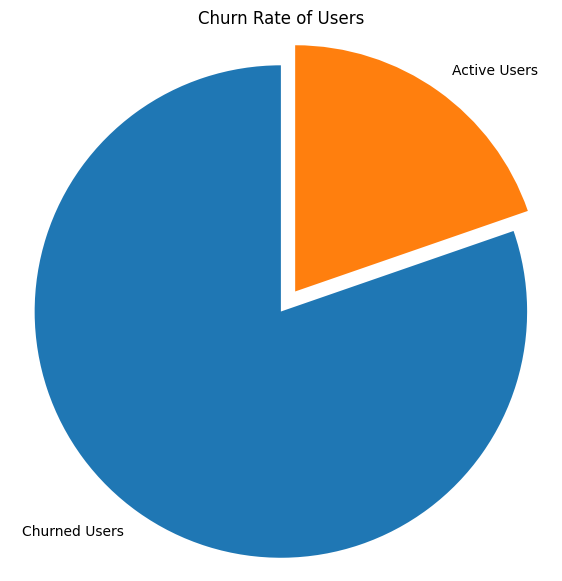

In [47]:
# churn rate of users
current_date = data['date_download'].max()
threshold_date = current_date - timedelta(days=30)

active_users = data[data['date_download'] >= threshold_date]['uid'].unique()
previous_users = data[data['date_download'] < threshold_date]['uid'].unique()

churned_users = [user for user in previous_users if user not in active_users]

total_users = len(data['uid'].unique())
churned_count = len(churned_users)
active_count = len(active_users)

churn_rate = (churned_count / total_users) * 100

print(f"churn Rate: {churn_rate:.2f}%")

labels = ['Churned Users', 'Active Users']
sizes = [churned_count, active_count]
explode = (0.1, 0)

plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, startangle=90, explode=explode)
plt.axis('equal')

plt.title('Churn Rate of Users')

plt.show()

country
AD    0.054219
AE    2.237126
AG    0.049504
AL    0.111974
AM    0.070721
        ...   
YE    0.029467
YT    0.005893
ZA    9.864334
ZM    0.200375
ZW    0.036539
Length: 193, dtype: float64


C:\Users\tellw\AppData\Local\Temp\ipykernel_12780\1423772584.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_by_country.values, y=churn_by_country.index, palette="viridis")


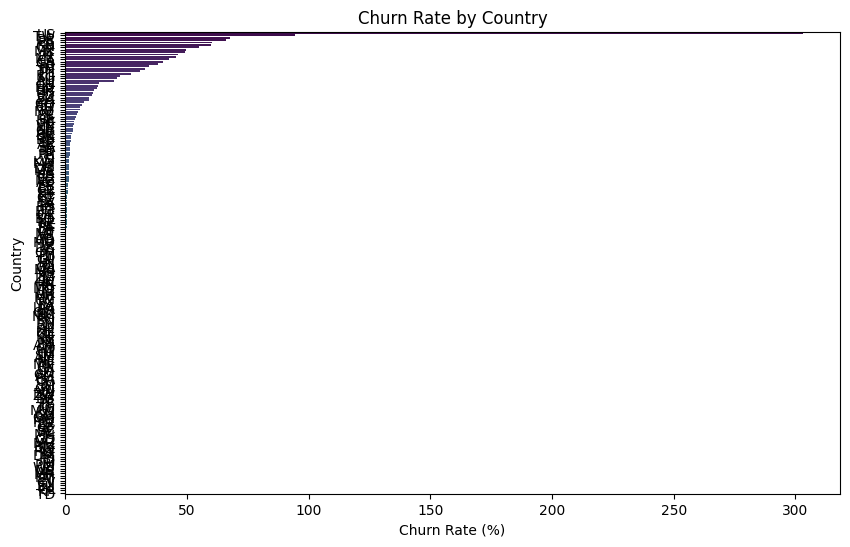

In [50]:
users_with_country = data[data['uid'].isin(churned_users)][['uid', 'country']]

churn_by_country = users_with_country.groupby('country').size() / len(data['uid'].unique()) * 100

print(churn_by_country)

churn_by_country = churn_by_country.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=churn_by_country.values, y=churn_by_country.index, palette="viridis")

plt.xlabel('Churn Rate (%)')
plt.ylabel('Country')
plt.title('Churn Rate by Country')

plt.show()